# Speech Emotion Recognition Project using an LSTM Model and RAVDESS Dataset

### Importing libraries

In [3]:
import numpy as np
import os
#from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
#import noisereduce as nr

import tensorflow as tf
import keras
import sklearn


import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Data Preparation

In [4]:
import os
import shutil

def organize_emotions(source_directory, target_directory):
    # Dictionary mapping from the letter in filename to emotion
    emotion_map = {
        'W': 'anger',
        'L': 'boredom',
        'E': 'disgust',
        'A': 'anxiety',
        'F': 'happiness',
        'T': 'sadness',
        'N': 'neutral'
    }
    
    # Create directories for each emotion if they don't exist
    for emotion in emotion_map.values():
        os.makedirs(os.path.join(target_directory, emotion), exist_ok=True)
    
    # Iterate through each file in the source directory
    for filename in os.listdir(source_directory):
        if filename.endswith('.wav'):  # Check if it's a WAV file
            if len(filename) > 5:  # Ensure the filename has the correct length
                emotion_code = filename[5]  # Extract the emotion letter from filename
                emotion_folder = emotion_map.get(emotion_code)
                
                if emotion_folder:  # Check if the emotion code is valid
                    # Path to the source file and target file
                    src_path = os.path.join(source_directory, filename)
                    dst_path = os.path.join(target_directory, emotion_folder, filename)
                    
                    # Copy the file to the appropriate emotion directory (instead of move)
                    shutil.copy(src_path, dst_path)
                    print(f'Copied {filename} to {emotion_folder}/')
                else:
                    print(f'Unknown emotion code "{emotion_code}" in file {filename}')
            else:
                print(f'Filename {filename} is too short to extract emotion code.')

# Usage example
source_dir = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav'  # Update this path
target_dir = '/kaggle/working/EMODB'  # Update this path
organize_emotions(source_dir, target_dir)


import os
import csv

def create_csv_from_emotion_folders(target_directory, output_csv):
    # List of emotions that are present in the target directory
    emotions = ['disgust', 'anger', 'happiness', 'boredom', 'neutral', 'anxiety', 'sadness']
    
    # Open the CSV file for writing
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Emotion', 'Path'])
        
        # Iterate through each emotion folder
        for emotion in emotions:
            emotion_folder = os.path.join(target_directory, emotion)
            
            # Check if the folder exists and iterate through its files
            if os.path.exists(emotion_folder):
                for filename in os.listdir(emotion_folder):
                    if filename.endswith('.wav'):  # Ensure it's a .wav file
                        file_path = os.path.join(emotion_folder, filename)
                        writer.writerow([emotion, file_path])  # Write emotion and file path

# Usage example
target_dir = '/kaggle/working/EMODB'  # The directory where the emotion folders are located
output_csv = '/kaggle/working/Emodb.csv'  # Path to the output CSV file
create_csv_from_emotion_folders(target_dir, output_csv)


Copied 15a04Fd.wav to happiness/
Copied 13b02Fb.wav to happiness/
Copied 09b01Wb.wav to anger/
Copied 15a01Wa.wav to anger/
Copied 14a05Wa.wav to anger/
Copied 03a05Aa.wav to anxiety/
Copied 11a04Wc.wav to anger/
Copied 09a05Tb.wav to sadness/
Copied 12a01Wc.wav to anger/
Copied 12a04Wc.wav to anger/
Copied 09a04La.wav to boredom/
Copied 08b02Nb.wav to neutral/
Copied 12b10Wa.wav to anger/
Copied 15a07Ld.wav to boredom/
Copied 10a07La.wav to boredom/
Copied 11a05Fb.wav to happiness/
Copied 03b01Nb.wav to neutral/
Copied 12b02Ea.wav to disgust/
Copied 08a01Ab.wav to anxiety/
Copied 10a01Ac.wav to anxiety/
Copied 12a02Wa.wav to anger/
Copied 14a02Fd.wav to happiness/
Copied 09a04Wa.wav to anger/
Copied 03b01Wa.wav to anger/
Copied 15a04Nc.wav to neutral/
Copied 09a05Lc.wav to boredom/
Copied 14a01Ea.wav to disgust/
Copied 09a02La.wav to boredom/
Copied 15b03Nb.wav to neutral/
Copied 14b02Wb.wav to anger/
Copied 12a07Ac.wav to anxiety/
Copied 11b01Wd.wav to anger/
Copied 08a07Wc.wav to an

,Emotion,Path
0,disgust,/kaggle/working/EMODB/disgust/14a07Eb.wav
1,disgust,/kaggle/working/EMODB/disgust/09a01Ea.wav
2,disgust,/kaggle/working/EMODB/disgust/15a02Ea.wav
3,disgust,/kaggle/working/EMODB/disgust/15a05Eb.wav
4,disgust,/kaggle/working/EMODB/disgust/14a01Ea.wav
5,disgust,/kaggle/working/EMODB/disgust/16a04Ea.wav
6,disgust,/kaggle/working/EMODB/disgust/14b10Eb.wav
7,disgust,/kaggle/working/EMODB/disgust/16a02Ea.wav
8,disgust,/kaggle/working/EMODB/disgust/14a04Ed.wav
9,disgust,/kaggle/working/EMODB/disgust/10b01Ea.wav


In [16]:
import pandas as pd
emodb = pd.read_csv("/kaggle/working/Emodb.csv")
emodb.head(10)

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def extract_features(data, sample_rate):
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate) 
    result = mfcc
    return result

def transform_audio(data, sample_rate, fns):
    fn = random.choice(fns)
    if fn == pitch:
        fn_data = fn(data, sample_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    fns = [noise, pitch, "None"]

    fn1_data = transform_audio(data, sample_rate, fns)
    fn2_data = transform_audio(fn1_data, sample_rate, fns)
    res1 = extract_features(fn2_data, sample_rate)
    result = [np.array(res1[:,:108])]

    fn1_data = transform_audio(data, sample_rate, fns)
    fn2_data = transform_audio(fn1_data, sample_rate, fns)
    res2 = extract_features(fn2_data, sample_rate)[:,:108]
    result.append(res2)

    fn1_data = transform_audio(data, sample_rate, fns)
    fn2_data = transform_audio(fn1_data, sample_rate, fns)
    res3 = extract_features(fn2_data, sample_rate)[:,:108]
    result.append(res3)

    return result

In [17]:
X, Y = [], []
for path, emotion in zip(emodb.Path.to_list(), emodb.Emotion.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            Y.append(emotion)

print("Feature extraction complete.")

Feature extraction complete.


In [18]:
X = np.array(X)
Y = np.array(Y)

In [19]:
X.shape, Y.shape

((519, 20, 108), (519,))

In [20]:
# One hot encoding y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [28]:
encoder.get_feature_names_out()

array(['x0_anger', 'x0_anxiety', 'x0_boredom', 'x0_disgust',
       'x0_happiness', 'x0_neutral', 'x0_sadness'], dtype=object)

In [29]:
# Split data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((415, 20, 108), (415, 7), (104, 20, 108), (104, 7))

### Model Development

In [24]:
input_shape = x_train.shape[1:]

In [35]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv1D, BatchNormalization, Flatten, LSTM, Dropout, Dense

input_shape = (20, 108, 1)

model=Sequential()

model.add(TimeDistributed(Conv1D(16, 3, padding='same', activation='relu'),
                            input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=7, activation='softmax'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_5              │ (None, 20, 108, 16)    │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 108, 16)    │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 1728)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │       225,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,823 (886.03 KB)

 Trainable params: 226,791 (885.90 KB)

 Non-trainable params: 32 (128.00 B)

In [36]:
from keras.optimizers import Adam
optimizer = Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 402ms/step - accuracy: 0.2220 - loss: 1.9166 - val_accuracy: 0.3173 - val_loss: 1.7378
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4425 - loss: 1.6226 - val_accuracy: 0.2885 - val_loss: 1.7751
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5349 - loss: 1.4278 - val_accuracy: 0.2981 - val_loss: 1.7955
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5860 - loss: 1.3535 - val_accuracy: 0.2885 - val_loss: 1.8631
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6945 - loss: 1.2046 - val_accuracy: 0.2885 - val_loss: 1.9082
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7407 - loss: 1.1062 - val_accuracy: 0.3269 - val_loss: 1.8167
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7188 - loss: 1.0239 - val_accuracy: 0.3750 - val_loss: 1.7139
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7896 - loss: 0.9260 - val_accuracy: 0.3846 - val_los

In [38]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred_emotion = encoder.inverse_transform(pred_test)

y_test_emotion = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_emotion.flatten()
df['Actual Labels'] = y_test_emotion.flatten()

df.head(10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step


,Predicted Labels,Actual Labels
0,happiness,happiness
1,sadness,disgust
2,sadness,happiness
3,anxiety,anger
4,sadness,boredom
5,sadness,boredom
6,sadness,sadness
7,happiness,anger
8,sadness,anger
9,sadness,boredom


### Model Evaluation

In [39]:
# Classification report
print(classification_report(y_test_emotion, y_pred_emotion))

              precision    recall  f1-score   support

       anger       1.00      0.14      0.25        14
     anxiety       0.00      0.00      0.00         4
     boredom       0.50      0.21      0.30        19
     disgust       1.00      0.05      0.09        21
   happiness       0.60      0.21      0.32        14
     neutral       0.00      0.00      0.00         5
     sadness       0.31      1.00      0.47        27

    accuracy                           0.36       104
   macro avg       0.49      0.23      0.20       104
weighted avg       0.59      0.36      0.27       104



4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3194 - loss: 3.1352
Testing Accuracy:  35.576921701431274 %


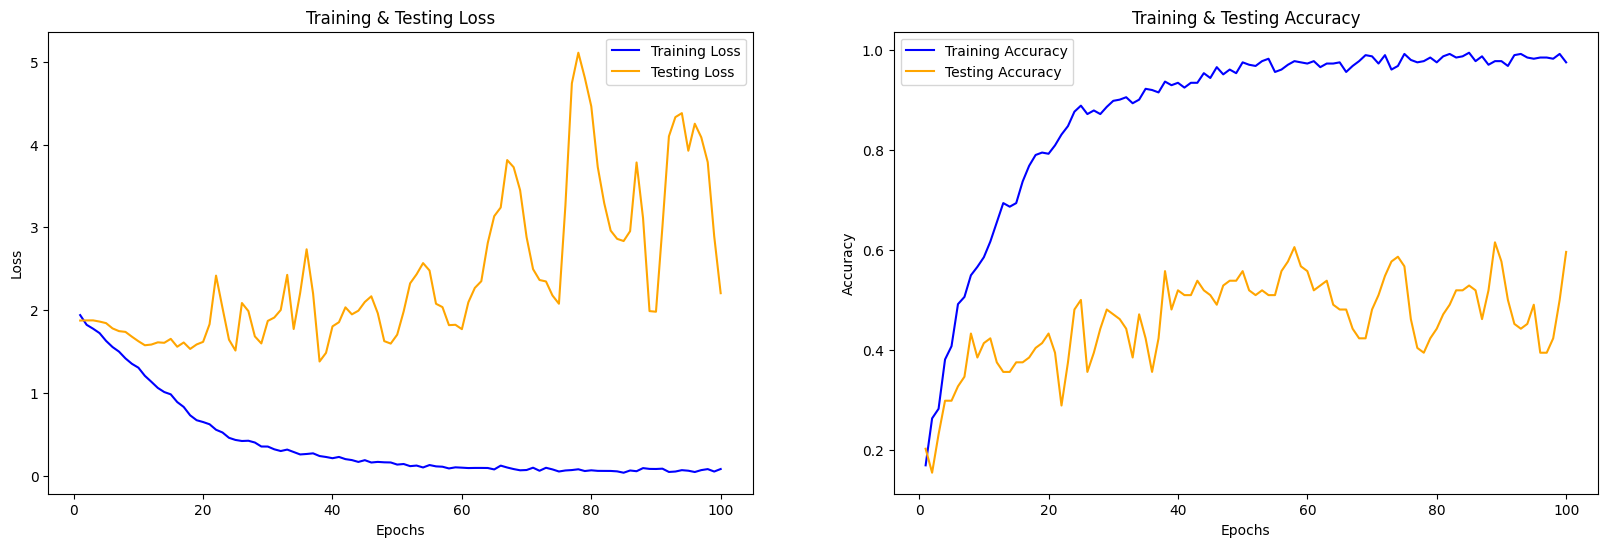

In [49]:
import matplotlib.pyplot as plt

# Assuming you've trained the model and have the history object

print("Testing Accuracy: ", model.evaluate(x_test, y_test)[1] * 100, "%")

# Define the number of epochs
epochs = [i for i in range(1, 101)]  # Since you've trained for 100 epochs

# Extract accuracy and loss values from the history
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Create subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot training and testing loss
ax[0].plot(epochs, train_loss, label='Training Loss', color='blue')
ax[0].plot(epochs, test_loss, label='Testing Loss', color='orange')
ax[0].set_title('Training & Testing Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and testing accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy', color='blue')
ax[1].plot(epochs, test_acc, label='Testing Accuracy', color='orange')
ax[1].set_title('Training & Testing Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plot
plt.show()


### Model Optimization

In [45]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv1D, BatchNormalization, Flatten, LSTM, Dropout, Dense

input_shape = (20, 108, 1)  # Add a channel dimension

model2 = Sequential()

model2.add(TimeDistributed(Conv1D(16, 3, padding='same', activation='relu'),
                           input_shape=input_shape))
model2.add(TimeDistributed(BatchNormalization()))

model2.add(TimeDistributed(Flatten()))
model2.add(LSTM(32))
model2.add(Dropout(0.25))  # Increased dropout rate to 0.25

model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(0.25))  # Increased dropout rate to 0.25

# Added an additional hidden layer
model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(0.25))  # Increased dropout rate to 0.25

model2.add(Dense(units=7, activation='softmax'))  # Changed the output layer to have 7 units

model2.summary()


from keras.optimizers import Adam
optimizer = Adam()
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_11             │ (None, 20, 108, 16)    │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 108, 16)    │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1728)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │       225,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,879 (890.15 KB)

 Trainable params: 227,847 (890.03 KB)

 Non-trainable params: 32 (128.00 B)

In [46]:
history = model2.fit(x_train, y_train, batch_size=100, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - accuracy: 0.1557 - loss: 1.9620 - val_accuracy: 0.2019 - val_loss: 1.8747
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2656 - loss: 1.8164 - val_accuracy: 0.1538 - val_loss: 1.8763
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2640 - loss: 1.8033 - val_accuracy: 0.2308 - val_loss: 1.8767
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3868 - loss: 1.7326 - val_accuracy: 0.2981 - val_loss: 1.8621
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4057 - loss: 1.6425 - val_accuracy: 0.2981 - val_loss: 1.8435
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4918 - loss: 1.5494 - val_accuracy: 0.3269 - val_loss: 1.7797
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5174 - loss: 1.4830 - val_accuracy: 0.3462 - val_loss: 1.7468
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5452 - loss: 1.4210 - val_accuracy: 0.4327 - val_los

In [47]:
pred_test = model2.predict(x_test)
y_pred_emotion = encoder.inverse_transform(pred_test)

y_test_emotion = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_emotion.flatten()
df['Actual Labels'] = y_test_emotion.flatten()

df.head(10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step


,Predicted Labels,Actual Labels
0,happiness,happiness
1,disgust,disgust
2,boredom,happiness
3,anger,anger
4,boredom,boredom
5,boredom,boredom
6,sadness,sadness
7,anger,anger
8,anger,anger
9,sadness,boredom


In [48]:
# Classification report
print(classification_report(y_test_emotion, y_pred_emotion))

              precision    recall  f1-score   support

       anger       0.88      0.50      0.64        14
     anxiety       1.00      0.25      0.40         4
     boredom       0.39      0.95      0.55        19
     disgust       0.78      0.33      0.47        21
   happiness       1.00      0.29      0.44        14
     neutral       0.00      0.00      0.00         5
     sadness       0.74      0.93      0.82        27

    accuracy                           0.60       104
   macro avg       0.68      0.46      0.47       104
weighted avg       0.71      0.60      0.57       104



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5780 - loss: 2.2293 
Testing Accuracy:  59.61538553237915 %


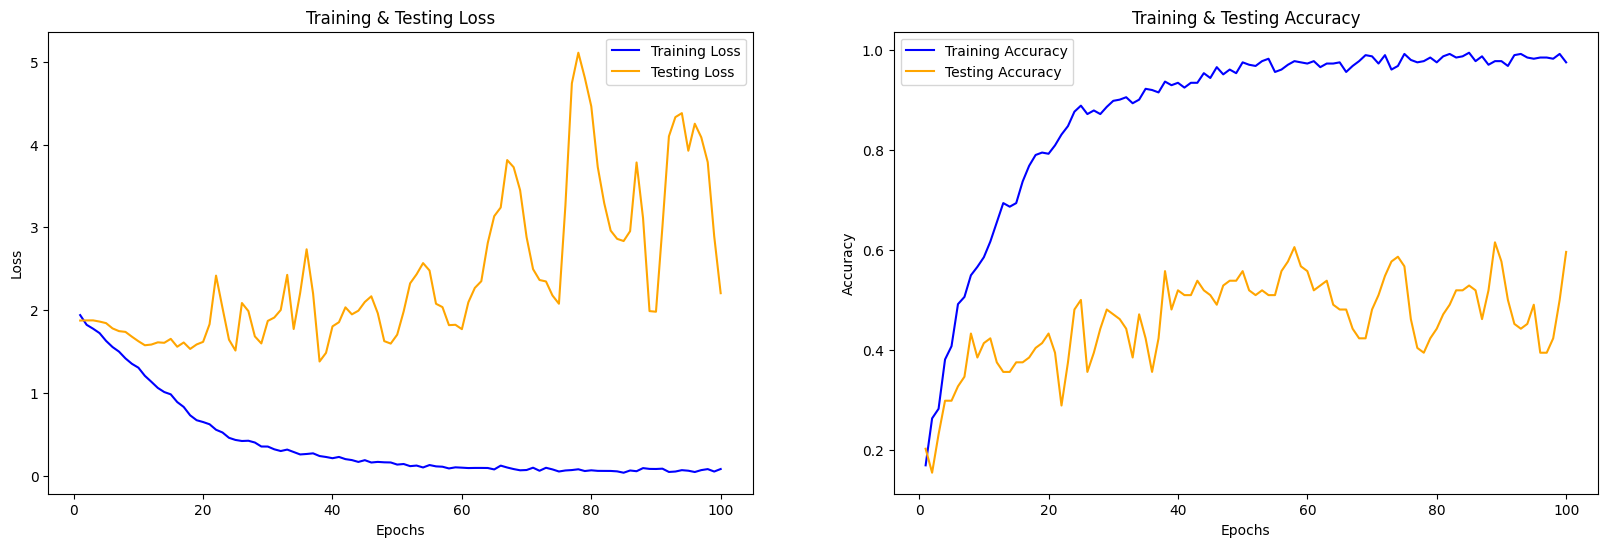

In [50]:
import matplotlib.pyplot as plt

# Assuming you've trained the model and have the history object

print("Testing Accuracy: ", model2.evaluate(x_test, y_test)[1] * 100, "%")

# Define the number of epochs
epochs = [i for i in range(1, 101)]  # Since you've trained for 100 epochs

# Extract accuracy and loss values from the history
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Create subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot training and testing loss
ax[0].plot(epochs, train_loss, label='Training Loss', color='blue')
ax[0].plot(epochs, test_loss, label='Testing Loss', color='orange')
ax[0].set_title('Training & Testing Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and testing accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy', color='blue')
ax[1].plot(epochs, test_acc, label='Testing Accuracy', color='orange')
ax[1].set_title('Training & Testing Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plot
plt.show()
